### Loading MNIST data
First, let’s start by loading the images and labels from the mnist-6k.npz file into an mnist dictionary.



In [1]:
import numpy as np

# Load data
with np.load("c4_mnist-6k.npz", allow_pickle=False) as npz_file:
    # Load items into a dictionary
    mnist = dict(npz_file.items())

mnist

{'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'labels': array([5, 0, 4, ..., 8, 6, 9])}

The dictionary contains a data entry with the pixel values of the 6,000 images and a labels one with their target values.

We will train our model on 5,000 train images, monitor the training process with a validation set of 500 images and use the 500 remaining ones to get a final test score.



In [2]:
from sklearn.model_selection import train_test_split

# Create train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    # Convert uint8 pixel values to float
    mnist["data"].astype(np.float32),
    mnist["labels"],
    test_size=1000,
    random_state=0,
)

# Split again into validation/test sets
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=500, random_state=0
)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_valid.shape, y_valid.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (5000, 784) (5000,)
Validation: (500, 784) (500,)
Test: (500, 784) (500,)


We split the data into train, validation and test sets by calling the train_test_split() function twice. The first time to extract a train set and the second time to separate the remaining images into validation and test sets. Note that we convert the pixel values to floating point numbers with the astype() function. That way, we won’t get warnings if we need to standardize X_train, X_valid or X_test later.

#### Softmax network
Let’s define our neural network. First, we need to initialize the model parameters.

In [3]:
import tensorflow as tf

# Initialize network parameters
W = tf.Variable(initial_value=tf.zeros(shape=[784, 10]))
b = tf.Variable(initial_value=tf.zeros(shape=[10]))

This code is similar to what we saw in the previous unit. We create the two variables and set their initial values with the initial_value parameter. We create a 
(784,10)matrix of zeros for the weights matrix using the zeros() function from TensorFlow. Similarly, we create a (10) vector of zeros for the biases vector.

Let’s now convert out training data into tensors in order to feed it to our TensorFlow network.



In [4]:
# Create input/target tensors
X = tf.constant(X_train)
y = tf.constant(y_train)

In [5]:
# We can now implement the formula from above to compute the matrix of logits Z
# Compute logits
logits = tf.add(tf.matmul(X, W), b)
print(logits.shape)

(5000, 10)


We use the matmul() function from TensorFlow to create a matrix multiplication operation and the add() function to add the bias values. We can verify that the shape of the logits matrix is (n,10) with the shape attribute of the logits tensor, where n= 500 is the number of data points.

Note that we can also pass the Numpy matrix X_train directly to the TensorFlow operation tf.matmul(). In general, TensorFlow operations take care of automatically converting the Numpy ndarray to TensorFlow tensors. To read more about Numpy compatibility with TensorFlow, you can check this page and this page.



In [6]:
# We can also pass the numpy matrix directly
logits = tf.add(tf.matmul(X_train, W), b)
print(logits.shape)


(5000, 10)


Now that we have a logits node that contains the predictions, let’s add a loss function node to evaluate them.

#### Cross-entropy loss function
We saw in the unit about logistic regressions that the loss function for logistic and softmax regressions is cross-entropy. TensorFlow implements a softmax_cross_entropy_with_logits() function that combines the softmax and cross-entropy operations. The function takes a matrix of logits and the target values and computes the cross-entropy score.

In [7]:
# Cross-entropy loss function
y_one_hot = tf.one_hot(indices=y, depth=10)
ce = tf.nn.softmax_cross_entropy_with_logits(
    labels=y_one_hot, logits=logits  # Requires one-hot encoded labels
)
print(ce.shape)


(5000,)


The function requires the target values to be one-hot encoded. To achieve this, we add a one-hot encoding operation with the one_hot() function. We pass the target node y with the indices argument and the number of classes with the depth one. We can then create the softmax with cross-entropy node ce which contains the cross-entropy score for each data point.

Note that TensorFlow also provides a sparse_softmax_cross_entropy_with_logits() function that doesn’t require the labels to be one-hot encoded.

In [8]:
# Cross-entropy loss function (without one-hot encoding)
ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
print(ce.shape)


(5000,)


In [9]:
#We can now compute the mean of the cross-entropy scores with the reduce_mean() function.

# Mean cross-entropy
mean_ce = tf.reduce_mean(ce)
print(mean_ce)

tf.Tensor(2.302591, shape=(), dtype=float32)


In [10]:
print(ce.shape)
print(mean_ce.shape)


(5000,)
()


Note that the ce and mean_ce tensors have a different shape. In the first case, the shape of ce is (5000,) which means that it’s a vector (1d tensor). In the second case, the shape of mean_ce is () which means that it’s a single value (0d tensor).

#### Optimizer
Finally, let’s define the optimizer using the code from the previous unit.

In [11]:
# Gradient descent
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

#### Measuring accuracy
In this example, we will also compute the accuracy of our predictions. We saw in the unit about logistic regressions that the softmax function assigns the highest probability to the class with the largest logit. To compute the accuracy of our network, let’s start by creating a predictions tensor with the class that has the maximum logit value using the argmax() function.

In [12]:
# Compute predictions
predictions = tf.argmax(
    logits,                # shape: (n, 10)
    axis=1,                # class with max logit
    output_type=tf.int32,  # Same type as labels
)
print(predictions.shape)

(5000,)


The function will return the index of the column (axis one) in the logits matrix with the largest value for each data point. Hence, we get a predictions tensor with one entry for each data point, and its shape is (5000,).

To compute the accuracy of our network, we need to compare these predictions to the target values. For this reason, the two tensors need to have the same data type. In the code from above, we set the data type of the output of the argmax() function with the output_type argument.

Let’s compare the predictions to the target values using the equal() function.

In [13]:
# Are the predictions correct?
is_correct = tf.equal(y, predictions)
print(is_correct.shape)


(5000,)


The is_correct variable is a tensor with a boolean value for each data point. The accuracy of our network is simply the proportion of True entries. To compute this accuracy value, we first convert the boolean values to numerical 0/1 values with the cast() function and then compute the mean with the reduce_mean() one.

In [14]:
# Accuracy
accuracy = tf.reduce_mean(
    # Convert booleans (false/true) to 0/1 float numbers
    tf.cast(is_correct, dtype=tf.float32)
)
print(accuracy.shape)

()


#### Side note about reduce_mean() and data types
Note that the reduce_mean() function returns a tensor with the same data type as its input. Hence, if we forget to convert our boolean values to floating points 0/1, we would get a mean of zero or one.



In [15]:
tf.reduce_mean(
    # Floating points 0/1 values
    [0.0, 0.0, 1.0, 1.0, 1.0]
)


<tf.Tensor: shape=(), dtype=float32, numpy=0.6>

In [16]:
tf.reduce_mean(
    # Integer 0/1 values
    [0, 0, 1, 1, 1]
)

<tf.Tensor: shape=(), dtype=int32, numpy=0>

In this code, we pass an array of 0/1 values to a reduce_mean() operation and run it in a session. It returns 0.6 when the values are floating point numbers but zero when they are encoded as integer values.

Now that we have built our network, let’s see how to train it.

#### Batch generator
In the last unit, we trained the network by running the training operation a hundred times using the entire data set. In practice, we often need to train neural networks on large data sets, and it’s usually not practical to train the network using the entire data. In particular, we need to be careful when training our network using GPUs since they have smaller memories than CPUs. For this reason, we usually train neural networks by small batches of data points.

Let’s create a function that iterates through our X/y arrays by small batches of data points using Python generators with the yield syntax. You can think of generators as a Python object that can be consumed by a for loop to iterate over a set of values (for more see here).

In [17]:
# Function to get batches of data
def get_batches(X, y, batch_size):
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # "yield" data between index i and i+b (not included)
        yield X[i : i + batch_size], y[i : i + batch_size]


get_batches(X_train, y_train, 64)

<generator object get_batches at 0x000001DEAE2556D0>

In this code, we define a get_batches() function that returns batches of data points from the X and y arrays of size batch_size. To achieve this, we generate an index i that ranges between zero and the number of data points by steps of size batch_size. For instance, if we have 10 data points and the batch size is 3, the i variable will take the values 0, 3, 6 and 9. To create the current batch, we extract rows of the X/y arrays between i and i+batch_size. In our example with ten data points, the function will create four batches.

* 1st batch - points 0, 1 and 2
* 2nd batch - points 3, 4 and 5
* 3rd batch - points 6, 7 and 8
* 4th batch - point 9

Let’s test our generator function in a for loop.

In [18]:
# Use generator in a "for" loop
batch_id = 0
for X_batch, y_batch in get_batches(X_train, y_train, 64):
    print("Batch X/y:", batch_id, X_batch.shape, y_batch.shape)
    
    batch_id += 1

Batch X/y: 0 (64, 784) (64,)
Batch X/y: 1 (64, 784) (64,)
Batch X/y: 2 (64, 784) (64,)
Batch X/y: 3 (64, 784) (64,)
Batch X/y: 4 (64, 784) (64,)
Batch X/y: 5 (64, 784) (64,)
Batch X/y: 6 (64, 784) (64,)
Batch X/y: 7 (64, 784) (64,)
Batch X/y: 8 (64, 784) (64,)
Batch X/y: 9 (64, 784) (64,)
Batch X/y: 10 (64, 784) (64,)
Batch X/y: 11 (64, 784) (64,)
Batch X/y: 12 (64, 784) (64,)
Batch X/y: 13 (64, 784) (64,)
Batch X/y: 14 (64, 784) (64,)
Batch X/y: 15 (64, 784) (64,)
Batch X/y: 16 (64, 784) (64,)
Batch X/y: 17 (64, 784) (64,)
Batch X/y: 18 (64, 784) (64,)
Batch X/y: 19 (64, 784) (64,)
Batch X/y: 20 (64, 784) (64,)
Batch X/y: 21 (64, 784) (64,)
Batch X/y: 22 (64, 784) (64,)
Batch X/y: 23 (64, 784) (64,)
Batch X/y: 24 (64, 784) (64,)
Batch X/y: 25 (64, 784) (64,)
Batch X/y: 26 (64, 784) (64,)
Batch X/y: 27 (64, 784) (64,)
Batch X/y: 28 (64, 784) (64,)
Batch X/y: 29 (64, 784) (64,)
Batch X/y: 30 (64, 784) (64,)
Batch X/y: 31 (64, 784) (64,)
Batch X/y: 32 (64, 784) (64,)
Batch X/y: 33 (64, 7

In this code, we set the batch size to 64, and get batches of 64 data points (except for the last batch which has 8 data points).

#### Training (eager execution mode)
Let’s train our network by adapting the code from the previous unit.

In [19]:
# Accuracy score after each batch of data
acc_values = []

# Get batches of data
for X_batch, y_batch in get_batches(X_train, y_train, 64):
    # Run training operation
    with tf.GradientTape() as tape:
        logits = tf.add(tf.matmul(X_batch, W), b)
        ce = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y_batch, logits=logits
        )
        mean_ce = tf.reduce_mean(ce)
    optimizer.minimize(loss=mean_ce, var_list=[W, b], tape=tape)

    # Compute predictions
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)

    # Compute accuracy
    is_correct = tf.equal(y_batch, predictions)
    batch_acc = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

    acc_values.append(batch_acc)

# Get weight matrix and biases
W_fitted = W.numpy()
b_fitted = b.numpy()

We run the training operation by batches of data and save the batch accuracy values in an acc_values variable. At the end, we get the weights matrix and the biases vector with the numpy() function converts TensorFlow tensors to Numpy arrays.

Let’s plot the accuracy values and then compute the mean train accuracy of the last 20 batches.

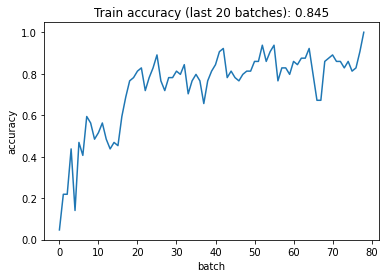

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(acc_values)
plt.title(
    "Train accuracy (last 20 batches): {:.3f}".format(
        # Average accuracy value
        np.mean(acc_values[-20:])
    )
)
plt.xlabel("batch")
plt.ylabel("accuracy")
plt.show()


Since we evaluate the accuracy on only 64 data points, our accuracy measure is not very precise and varies a lot between each batch of data. However, it’s clear that our network is learning and the final test accuracy should be between 80% and 90% if we didn’t overfit.

#### Visualize templates
We saw above that each output neuron learns from the data by tuning its synaptic weights (the columns of W). These weights are the signature of each output neuron. They tell us what each neuron tries to detect in the input. In our case, each weight corresponds to a pixel in our 28 by 28 images. Hence, we can plot these weights to get templates of digits learned by each neuron.



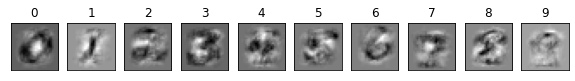

In [21]:
# Create figure with 10 subplots
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 2))

# Plot the weights for each class in a subplot
for i, axis in enumerate(axes):
    # Get weights of the i-th class
    weights = W_fitted[:, i]

    # Reshape weight values into a 28x28 array
    template = weights.reshape(28, 28)

    # Plot array
    axis.imshow(template, plt.cm.gray_r)  # Grayscale (reversed)
    axis.get_xaxis().set_visible(False)   # disable x-axis
    axis.get_yaxis().set_visible(False)   # disable y-axis
    axis.set_title(i)                     # Adds title to image

plt.show()

In this code, we create a figure with ten subplots using the subplots() function from Pyplot and get a list of axes. We plot each template by enumerating the axes. The axis and the i variables in the for loop contain each axis and its index in the list of axes. We use the index to extract the weights of the i-th output neuron and reshape these weights into a 28 by 28 array that we can then plot by calling the imshow() function of the axis object. Note that we hide the x and y axes with the set_visible() function.

These ten templates define what each neuron expects. Black areas correspond to pixels that “stimulate” the output neuron, gray areas correspond to pixels that have a small impact on the output, and white areas correspond to pixels that decrease the activity of the neuron. For instance, the template for images of zeros will detect images (positive logit) with positive pixel values on the circle around the center of the image (black area) but reject ones (negative logit value) with positive pixel values in the center of the image (white area).

#### Improve learning
The digits in the templates from above are not perfectly smooth. There seems to be some noise. We saw in the last course that gradient descent is sensitive to the scale of the data. Let’s try to improve learning by standardizing the input data.

We can use the StandardScaler object from Scikit-learn.

In [22]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object and fit it to train data
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

Let’s run the training process with the standardized data. This time, we will also monitor the validation accuracy.



In [24]:
# Accuracy scores after each batch
train_acc_values = []
valid_acc_values = []

# Reinitialize the network parameters to zero
W = tf.Variable(initial_value=tf.zeros(shape=[784, 10]))
b = tf.Variable(initial_value=tf.zeros(shape=[10]))

# Reinitialize gradient descent and decrease the learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

# Rescale input data
X_train_rescaled = scaler.transform(X_train)
X_valid_rescaled = scaler.transform(X_valid)


# Get batches of data
for X_batch, y_batch in get_batches(X_train_rescaled, y_train, 64):
    # Run training
    with tf.GradientTape() as tape:
        train_logits = tf.add(tf.matmul(X_batch, W), b)
        ce = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y_batch, logits=train_logits
        )
        mean_ce = tf.reduce_mean(ce)
    optimizer.minimize(loss=mean_ce, var_list=[W, b], tape=tape)

    # Evaluate training accuracy
    predictions = tf.argmax(train_logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y_batch, predictions)
    train_acc = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    train_acc_values.append(train_acc)

    # Evaluate validation accuracy
    valid_logits = tf.add(tf.matmul(X_valid_rescaled, W), b)
    valid_predictions = tf.argmax(valid_logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y_valid, valid_predictions)
    valid_acc = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    valid_acc_values.append(valid_acc)

# Get weight matrix and biases
W_fitted = W.numpy()
b_fitted = b.numpy()

In this code, we rescale the train and validation data and then run the training operation in batches. At each iteration, we compute the accuracy on the current training batch and the accuracy on the validation set, and we store the values in the train_acc_values and valid_acc_values variables. Finally, we evaluate the synaptic weights and biases.

Let’s plot the accuracy values.

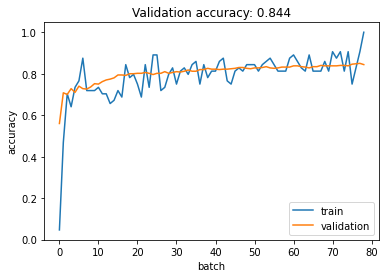

In [25]:
# Plot accuracy values
plt.plot(train_acc_values, label="train")
plt.plot(valid_acc_values, label="validation")
plt.title(
    "Validation accuracy: {:.3f}".format(
        valid_acc_values[-1]  # Last validation accuracy value
    )
)
plt.xlabel("batch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

By looking at the two curves, it doesn’t seem that the model is overfitting. Both curves increase, and the last validation accuracy is around 85%.

Let’s rerun the code from above to plot the values in the weights matrix W_fitted.



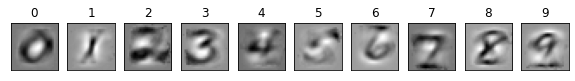

In [26]:
# Create figure with 10 subplots
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 2))

# Plot the weights for each class in a subplot
for i, axis in enumerate(axes):
    # Get weights of the i-th class
    weights = W_fitted[:, i]

    # Reshape weight values into a 28x28 array
    template = weights.reshape(28, 28)

    # Plot array
    axis.imshow(template, plt.cm.gray_r)  # Grayscale (reversed)
    axis.get_xaxis().set_visible(False)   # disable x-axis
    axis.get_yaxis().set_visible(False)   # disable y-axis
    axis.set_title(i)                     # Adds title to image

plt.show()

This time, the noise in the templates disappeared, and we can clearly recognize each digit.

Finally, let’s compute a final accuracy measure using the test set.

In [28]:
# Evaluate validation accuracy
X_test_rescaled = scaler.transform(X_test)

test_logits = tf.add(tf.matmul(X_test_rescaled, W), b)
test_predictions = tf.argmax(test_logits, axis=1, output_type=tf.int32)

is_correct = tf.equal(y_test, test_predictions)
test_acc = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

print("Test accuracy: {:.3f}".format(test_acc))


Test accuracy: 0.850


Note that in order to evaluate the validation accuracy, we also need to rescale our input test data using the scaler object from above. We get a final accuracy measure around 85%.

#### Training (graph mode)
To better organize the previous code, we are going to repeat everything while refactoring the code into Python functions. Moreover, we will use the tf.function decorator to activate the graph mode.

Let’s first define the optimizer and rewrite all the required operations as functions.

In [29]:
# Define the optimizer (if not done yet)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
# Compute the logits
@tf.function
def compute_logits(x, W, b):
    logits = tf.add(tf.matmul(x, W), b)
    return logits


# Compute the loss
@tf.function
def compute_loss(y, logits):
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    mean_ce = tf.reduce_mean(ce)
    return mean_ce


# Compute the accuracy
@tf.function
def compute_accuracy(y, logits):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    acc = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    return acc


# Train the model (optimization procedure)
@tf.function
def train(x, y, W, b):
    with tf.GradientTape() as tape:
        logits = compute_logits(x, W, b)
        loss = compute_loss(y, logits)
    optimizer.minimize(loss=loss, var_list=[W, b], tape=tape)
    return logits, loss

We will now reinitialize the model parameters and train the network using the functions defined above. This yields a more compact code as you can see below.

In [30]:
# Accuracy scores after each batch
train_acc_values = []
valid_acc_values = []

# Reinitialize the network parameters to zero
W = tf.Variable(initial_value=tf.zeros(shape=[784, 10]))
b = tf.Variable(initial_value=tf.zeros(shape=[10]))


# Get batches of data
for X_batch, y_batch in get_batches(X_train_rescaled, y_train, 64):
    # Run training
    train_logits, _ = train(X_batch, y_batch, W, b)

    # Evaluate training accuracy
    train_acc = compute_accuracy(y_batch, train_logits)
    train_acc_values.append(train_acc)

    # Evaluate validation accuracy
    valid_logits = compute_logits(X_valid_rescaled, W, b)
    valid_acc = compute_accuracy(y_valid, valid_logits)
    valid_acc_values.append(valid_acc)

# Get weight matrix and biases
W_fitted = W.numpy()
b_fitted = b.numpy()

The performance results will be exactly the same as before. However, the training speed can be faster thanks to the graph mode. You can use the code from above to plot the values of the accuracy and the weights matrix.